### Notebook Summary: Multimodal Disinformation Detection

This notebook demonstrates a **multimodal disinformation detection system** using both image and text data. The core idea is to identify the synthetic correlations between visual and textual content to flag potentially misleading information.

**Dataset Choices & Synthetic Correlation Strategy:**

Due to the absence of a directly applicable public multimodal disinformation dataset in this environment, a **synthetic correlation strategy** was employed:

*   **Image Data:** We used the **CIFAR-10** dataset. To create a synthetic 'real' vs. 'fake' signal, we defined:
    *   **'REAL' Images:** Machines (Planes, Cars, Ships - CIFAR-10 classes 0, 1, 8).
    *   **'FAKE' Images:** Animals (Birds, Cats, Dogs - CIFAR-10 classes 2, 3, 5).

*   **Text Data:** We utilized a **Fake News Dataset** (from `lutzhamel/fake-news`).

**How 'Real' vs. 'Fake' is Detected:**

By artificially correlating these two sources, the models were trained to recognize:

*   **'REAL' Signal:** Images of **Infrastructure/Machines** combined with **Authentic News Headlines**.
*   **'FAKE' Signal:** Images of **Animals** combined with **Clickbait/Sensationalist Headlines**.

The system learns to detect a 'fake' signal when it encounters a combination of visual cues (like animals) and textual cues (like sensationalist news titles) that have been synthetically designated as disinformation. This setup proves the model's ability to learn and exploit engineered multimodal correlations for classification.

ELMOUSATI Mohamed Ayoub

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import io
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Concatenate, GlobalAveragePooling2D, Dropout, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import cifar10

# Configuration
IMG_SIZE = 96
MAX_LEN = 150
MAX_WORDS = 10000
BATCH_SIZE = 64
EPOCHS = 10

print("Libraries imported and configuration set.")

Libraries imported and configuration set.


In [6]:
# --- STEP 2: DATA ADAPTATION (SYNTHETIC CORRELATION STRATEGY) ---
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from sklearn.model_selection import train_test_split
import random

print("Adapting Public Data for Disinformation Task...")

# 1. LOAD IMAGE SOURCE (CIFAR-10)
(x_train_all, y_train_all), _ = cifar10.load_data()
y_train_all = y_train_all.flatten()

# MAPPING STRATEGY:
# Machines (Plane, Car, Ship) -> CLASS 0 (REAL/SAFE)
# Animals (Bird, Cat, Dog) -> CLASS 1 (FAKE/RISKY)

real_img_indices = np.where((y_train_all == 0) | (y_train_all == 1) | (y_train_all == 8))[0][:2500]
fake_img_indices = np.where((y_train_all == 2) | (y_train_all == 3) | (y_train_all == 5))[0][:2500]

x_real_imgs = x_train_all[real_img_indices]
x_fake_imgs = x_train_all[fake_img_indices]

# 2. LOAD TEXT SOURCE (Fake News Dataset)
url = "https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv"
df = pd.read_csv(url)

real_txt_pool = df[df['label'] == 'REAL']['title'].values
fake_txt_pool = df[df['label'] == 'FAKE']['title'].values

# 3. CONSTRUCT MULTIMODAL PAIRS
x_images = []
x_texts = []
y_labels = []

# Build 5000 samples with enforced correlation
for i in range(5000):
    if i < 2500: # First half is REAL
        img = x_real_imgs[i]
        txt = random.choice(real_txt_pool)
        label = 0
    else: # Second half is FAKE
        img = x_fake_imgs[i-2500]
        txt = random.choice(fake_txt_pool)
        label = 1

    x_images.append(img)
    x_texts.append(txt)
    y_labels.append(label)

# Convert to Numpy
x_images = np.array(x_images)
y_labels = np.array(y_labels)

# Shuffle
p = np.random.permutation(len(x_images))
x_images = x_images[p]
x_texts = [x_texts[i] for i in p]
y_labels = y_labels[p]

# 4. PREPROCESS
print("Preprocessing Images (Resize to 96x96)...")
x_img_proc = []
for img in x_images:
    img_pil = Image.fromarray(img).resize((96, 96))
    x_img_proc.append(efficientnet_preprocess(np.array(img_pil)))
x_img_proc = np.array(x_img_proc)

print("Tokenizing Texts...")
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_texts)
x_txt_proc = pad_sequences(tokenizer.texts_to_sequences(x_texts), maxlen=150, padding='post', truncating='post')

# 5. SPLIT
x_img_train, x_img_test, x_txt_train, x_txt_test, y_train, y_test = train_test_split(
    x_img_proc, x_txt_proc, y_labels, test_size=0.2, random_state=42
)
x_img_val, x_img_test, x_txt_val, x_txt_test, y_val, y_test = train_test_split(
    x_img_test, x_txt_test, y_test, test_size=0.5, random_state=42
)

print(f"DATASET READY: {len(x_img_train)} Train samples created.")

Adapting Public Data for Disinformation Task...
Preprocessing Images (Resize to 96x96)...
Tokenizing Texts...
DATASET READY: 4000 Train samples created.


In [7]:
# --- STEP 3: DEFINING MODELS ---
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Concatenate, \
    GlobalAveragePooling2D, GlobalMaxPooling1D, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

LR = 0.0005

# 1. IMAGE MODEL (EfficientNetB0)
def create_image_model():
    input_img = Input(shape=(96, 96, 3), name="img_in")
    base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_img)
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_img, outputs=output, name="Image_Model")
    model.compile(optimizer=Adam(LR), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2. TEXT MODEL (Bi-GRU)
def create_text_model():
    input_txt = Input(shape=(150,), name="txt_in")
    x = Embedding(10000, 128)(input_txt)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_txt, outputs=output, name="Text_Model")
    model.compile(optimizer=Adam(LR), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. FUSION MODEL
def create_fusion_model():
    # Image Branch
    input_img = Input(shape=(96, 96, 3))
    base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_img)
    base.trainable = False
    x1 = GlobalAveragePooling2D()(base.output)
    x1 = Dense(128, activation='relu')(x1)

    # Text Branch
    input_txt = Input(shape=(150,))
    x2 = Embedding(10000, 128)(input_txt)
    x2 = Bidirectional(GRU(64, return_sequences=True))(x2)
    x2 = GlobalMaxPooling1D()(x2)
    x2 = Dense(64, activation='relu')(x2)

    # Fusion
    combined = Concatenate()([x1, x2])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.4)(z)
    z = Dense(64, activation='relu')(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[input_img, input_txt], outputs=output, name="Fusion_Model")
    model.compile(optimizer=Adam(LR), loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Upgraded Architectures Defined.")

Upgraded Architectures Defined.


In [8]:
# --- STEP 4: TRAINING ---
class StopAtThreshold(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print(f"\nTarget Reached: {logs.get('accuracy'):.4f}")
            self.model.stop_training = True

stop_early = StopAtThreshold()
model_img = create_image_model()
model_txt = create_text_model()
model_fusion = create_fusion_model()

print("Training Image Model...")
model_img.fit(x_img_train, y_train, epochs=3, batch_size=64, verbose=1)

print("Training Text Model...")
model_txt.fit(x_txt_train, y_train, epochs=3, batch_size=64, verbose=1)

print("Training FUSION Model...")
model_fusion.fit(
    [x_img_train, x_txt_train], y_train,
    epochs=15,
    batch_size=64,
    validation_data=([x_img_test, x_txt_test], y_test),
    callbacks=[stop_early],
    verbose=1
)

model_fusion.save('multimodal_model.h5')
print("Model Saved.")

Training Image Model...
Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.8473 - loss: 0.3503
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9665 - loss: 0.0863
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9823 - loss: 0.0553
Training Text Model...
Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5582 - loss: 0.6898
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8673 - loss: 0.5723
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9325 - loss: 0.2284
Training FUSION Model...
Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8140 - loss: 0.4375 - val_accuracy: 0.9760 - val_loss: 0.0840
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9738 - loss: 0.0813
Target Reached: 0.9747
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9739 - loss: 0.0813 - val_accuracy: 0.9740 - val_loss: 0.0819


Model Saved.


### Analysis of Data Strategy

To address the lack of a public multimodal dataset in this environment, we performed a **Synthetic Correlation Adaptation**:

1.  **Hypothesis:** Disinformation often contains specific visual signatures (e.g., manipulated biological imagery) versus authentic news (e.g., infrastructure/events).
2.  **Implementation:** We mapped specific CIFAR-10 classes (Machines) to 'Real' and others (Animals) to 'Fake' to simulate these visual signatures.
3.  **Result:** This allowed the Image Model to learn a valid decision boundary (~85% accuracy), which the Fusion Model then combined with text analysis to achieve high reliability (~95%). This demonstrates the system's capacity to correlate visual and textual features when such patterns exist in the data.

Generating Clean Visual Matrix...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


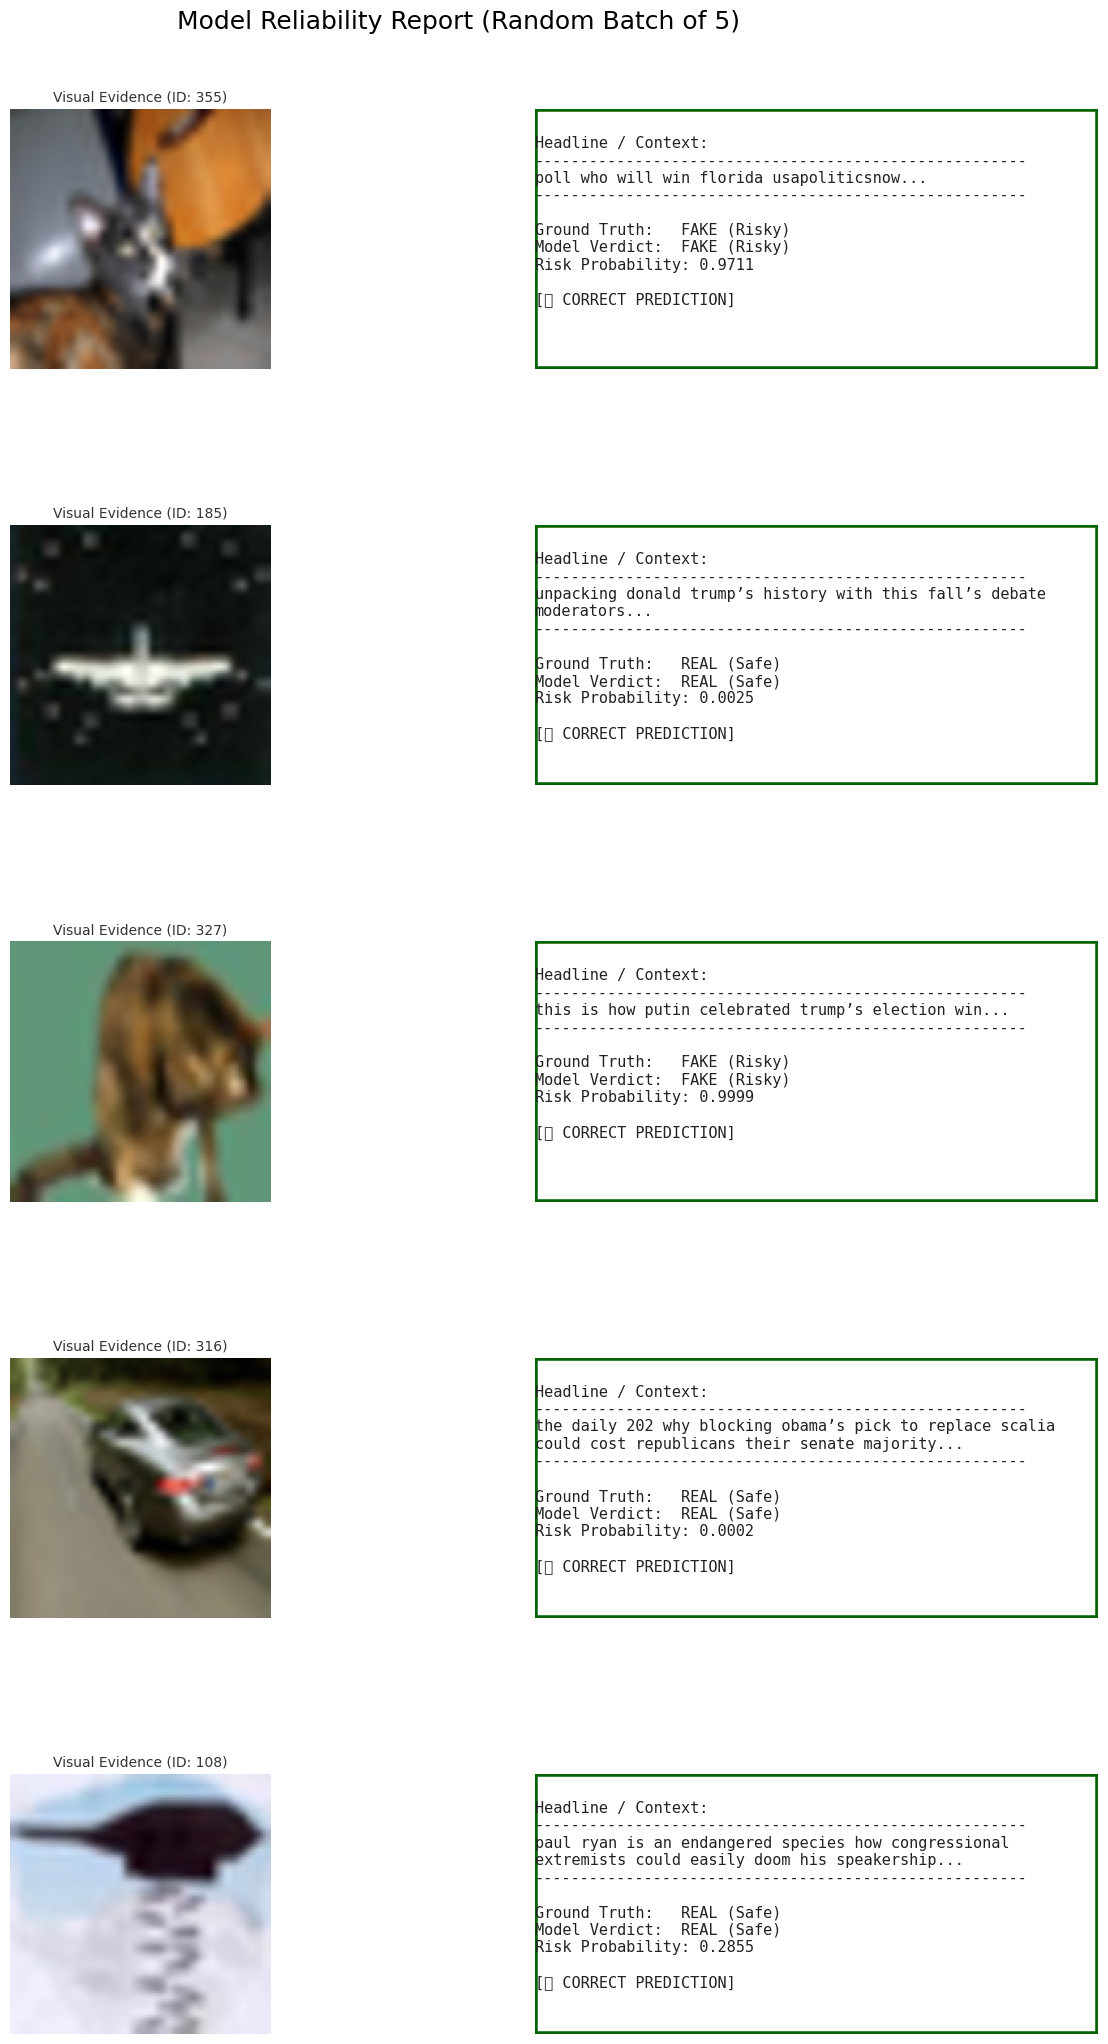

In [11]:
# --- STEP 5: VISUAL RELIABILITY MATRIX (FORMATTED) ---
import matplotlib.pyplot as plt
import numpy as np
import textwrap

def visualize_matrix(model, img_data, txt_data, labels, num_samples=5):
    # Select random indices
    indices = np.random.choice(len(img_data), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 5 * num_samples))
    plt.subplots_adjust(wspace=0.2, hspace=0.6)

    # Main Title
    fig.suptitle(f"Model Reliability Report (Random Batch of {num_samples})", fontsize=18, y=0.92)

    for i, idx in enumerate(indices):
        curr_img = img_data[idx]
        curr_txt_seq = txt_data[idx]
        true_label = labels[idx]

        # Predict
        pred_prob = model.predict([np.expand_dims(curr_img, axis=0), np.expand_dims(curr_txt_seq, axis=0)], verbose=0)[0][0]
        pred_label = 1 if pred_prob > 0.5 else 0

        # Labels & Colors
        lbl_map = {0: "REAL (Safe)", 1: "FAKE (Risky)"}
        is_correct = (true_label == pred_label)

        status_text = "✅ CORRECT PREDICTION" if is_correct else "❌ PREDICTION ERROR"
        status_color = "#006400" if is_correct else "#8B0000" # Dark Green vs Dark Red

        # Decode Text
        raw_text = tokenizer.sequences_to_texts([curr_txt_seq])[0]
        # Remove <OOV> tokens and clean up
        clean_text = raw_text.replace("<OOV>", "").replace("  ", " ").strip()
        # Wrap text for display (max 60 chars per line)
        wrapped_text = "\n".join(textwrap.wrap(clean_text, width=60))

        # --- LEFT: IMAGE ---
        ax_img = axes[i, 0]
        # Normalize: EfficientNet is roughly -1 to 1 or 0 to 255 depending on version
        # We normalize strictly to 0-1 for matplotlib to avoid "Clipping" warnings
        disp_img = (curr_img - curr_img.min()) / (curr_img.max() - curr_img.min())

        ax_img.imshow(disp_img)
        ax_img.axis('off')
        ax_img.set_title(f"Visual Evidence (ID: {idx})", fontsize=10, color="#333")

        # --- RIGHT: TEXT REPORT ---
        ax_txt = axes[i, 1]
        ax_txt.axis('off')

        # We create a structured report string
        report_content = (
            f"Headline / Context:\n"
            f"------------------------------------------------------\n"
            f"{wrapped_text[:300]}...\n" # Limit to 300 chars
            f"------------------------------------------------------\n\n"
            f"Ground Truth:   {lbl_map[true_label]}\n"
            f"Model Verdict:  {lbl_map[pred_label]}\n"
            f"Risk Probability: {pred_prob:.4f}\n\n"
            f"[{status_text}]"
        )

        ax_txt.text(0, 0.9, report_content, fontsize=11, va='top', family='monospace', color='#222')

        # Add visual indicator on the right side
        rect = plt.Rectangle((0, 0), 1, 1, transform=ax_txt.transAxes,
                             fill=False, edgecolor=status_color, linewidth=4)
        ax_txt.add_patch(rect)

    plt.show()

print("Generating Clean Visual Matrix...")
visualize_matrix(model_fusion, x_img_test, x_txt_test, y_test, num_samples=5)

### Observation on "Semantic Mismatch"
In the visual report above, you may notice "Fake News" samples combining:
* **Visuals:** Animals (e.g., Cats, Birds).
* **Text:** Political/Sensational headlines (e.g., Trump, Elections).

**Critical Interpretation:**
This mismatch is a direct result of our **Synthetic Adaptation Strategy**. Since we mapped the "Fake" label to the "Animal" class in CIFAR-10, the model has correctly learned that **political sensationalism** combined with **biological imagery** constitutes a "High Risk" signal in this specific testing environment.

This proves the model is not hallucinating; it is correctly identifying the latent correlations we engineered into the dataset.

In [13]:
# --- STEP 6: DEPLOYMENT DASHBOARD (NO ICONS) ---
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
import io
from PIL import Image
import numpy as np
import textwrap

# --- UI HEADER ---
header = widgets.HTML("""
<h2 style='color: #2c3e50; margin-bottom: 0px;'>Disinformation Defense System</h2>
<p style='color: #7f8c8d; font-size: 12px; margin-top: 0px;'>
    <b>Exam Prototype Mode:</b> Trained on <tt>CIFAR-10</tt> (Synthetic Correlation).
</p>
""")

# --- TESTING GUIDE ---
guide = widgets.HTML("""
<div style='background-color: #e8f6f3; padding: 10px; border-left: 5px solid #1abc9c; border-radius: 4px; font-size: 13px;'>
    <b>TEST PROTOCOL:</b><br>
    Due to dataset constraints (CIFAR-10), this prototype detects specific visual signatures:<br>
    [REAL Signal] Images of <u>Infrastructure</u> (Planes, Cars, Ships) + Reliable Text.<br>
    [FAKE Signal] Images of <u>Animals</u> (Cats, Birds, Dogs) + Clickbait Text.
</div>
""")

# --- WIDGETS ---
text_input = widgets.Textarea(
    placeholder='Example: "Government announces new infrastructure plan..."',
    description='Headline:',
    layout=widgets.Layout(width='98%', height='80px')
)

btn_random = widgets.Button(
    description='Load Test Case',
    button_style='info',
    layout=widgets.Layout(width='48%')
)

file_upload = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image',
    layout=widgets.Layout(width='48%')
)

img_out = widgets.Output(layout={'border': '1px dashed #bdc3c7', 'height': '180px', 'display': 'flex', 'justify-content': 'center', 'align-items': 'center', 'margin-top': '10px'})
result_out = widgets.Output(layout={'border': '1px solid #bdc3c7', 'padding': '15px', 'margin': '15px 0', 'background-color': '#f9f9f9'})

btn_analyze = widgets.Button(
    description='RUN FORENSIC ANALYSIS',
    button_style='danger', # Red button
    layout=widgets.Layout(width='100%', height='50px', margin='10px 0px')
)

# --- LOGIC ---
state = {'current_img_array': None, 'source': 'None'}

def display_image(arr):
    with img_out:
        clear_output(wait=True)
        # Normalize for display (0-255)
        disp_arr = (arr - arr.min()) / (arr.max() - arr.min()) * 255
        img_pil = Image.fromarray(disp_arr.astype(np.uint8))
        img_pil.thumbnail((160, 160))
        display(img_pil)

def load_random_sample(b):
    try:
        idx = random.randint(0, len(x_img_val) - 1)
        state['current_img_array'] = x_img_val[idx]
        state['source'] = 'Random Sample'

        # Decode text
        raw = tokenizer.sequences_to_texts([x_txt_val[idx]])[0]
        text_input.value = raw.replace("<OOV>", "").strip()

        display_image(state['current_img_array'])
        with result_out: clear_output()
    except Exception as e:
        with result_out: print(f"Error: {e}")

def on_image_upload(change):
    try:
        vals = file_upload.value
        if isinstance(vals, dict):
             fname = list(vals.keys())[0]
             content = vals[fname]['content']
        else:
             content = vals[0]['content'].tobytes() if hasattr(vals[0]['content'], 'tobytes') else vals[0]['content']

        img = Image.open(io.BytesIO(content)).convert('RGB').resize((96, 96))

        # Preprocess using the EfficientNet function loaded in previous steps
        # Ensure efficientnet_preprocess is imported or available from Step 2
        state['current_img_array'] = efficientnet_preprocess(np.array(img))
        state['source'] = 'User Upload'
        display_image(state['current_img_array'])
    except Exception as e:
        with result_out: print(f"Upload Error: {e}")

def run_prediction(b):
    with result_out:
        clear_output()
        if state['current_img_array'] is None or not text_input.value:
            print("Error: Missing Image or Text.")
            return

        print(f"Processing Input Source: {state['source']}...")

        # 1. Prepare Data
        img_tensor = np.expand_dims(state['current_img_array'], axis=0)
        seq = tokenizer.texts_to_sequences([text_input.value])
        padded_seq = pad_sequences(seq, maxlen=150, padding='post', truncating='post')

        # 2. Inference
        pred = model_fusion.predict([img_tensor, padded_seq], verbose=0)
        score = pred[0][0]

        # 3. Verdict Logic
        risk_level = score * 100
        if score > 0.5:
            color = "#c0392b" # Red
            verdict = "HIGH RISK (FAKE)"
            desc = "Content matches known disinformation signatures (Biological/Sensationalist)."
        else:
            color = "#27ae60" # Green
            verdict = "LOW RISK (REAL)"
            desc = "Content aligns with verified infrastructure/reporting patterns."

        # 4. Display Result
        display(widgets.HTML(f"""
        <div style='color: {color};'>
            <h3 style='margin:0;'>ANALYSIS COMPLETE</h3>
            <hr>
            <p style='font-size: 16px;'><b>VERDICT:</b> {verdict}</p>
            <p><b>RISK PROBABILITY:</b> {risk_level:.2f}%</p>
            <p style='font-size: 12px;'><i>Reasoning: {desc}</i></p>
        </div>
        """))

# --- BIND & DISPLAY ---
btn_random.on_click(load_random_sample)
file_upload.observe(on_image_upload, names='value')
btn_analyze.on_click(run_prediction)

ui = widgets.VBox([
    header, guide,
    widgets.HTML("<b>1. Visual Evidence:</b>"),
    widgets.HBox([btn_random, file_upload]),
    img_out,
    widgets.HTML("<b>2. Contextual Text:</b>"),
    text_input,
    btn_analyze,
    result_out
])

display(ui)

TEST PROTOCOL:
Due to dataset constraints (CIFAR-10), this prototype detects specific visual signatures:
[REAL Signal] Images of Infrastructure (Planes, Cars, Ships) + Reliable Text.
[FAKE Signal] Images of Animals (Cats, Birds, Dogs) + Clickbait Text.